#Waymo Open Dataset Tutorial (using local Jupyter kernel)

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset

This tutorial demonstrates how to use the Waymo Open Dataset with two frames of data. Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

To use:
1. checkout `waymo_open_dataset` (need to run once):
   ```
   git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-open-dataset-repo
   cd waymo-open-dataset-repo
   ```
2. build docker container (need to run once):
   ```
   docker build --tag=open_dataset -f tutorial/cpu-jupyter.Dockerfile .
   ```
3. start Jupyter kernel inside the docker container:
   ```
   docker run -p 8888:8888 open_dataset
   ```
4. connect the notebook to the local port `8888`.

Uncheck the box "Reset all runtimes before running" if you run this colab directly from the remote kernel. Alternatively, you can make a copy before trying to run it by following "File > Save copy in Drive ...".



### Metrics computation
The core metrics computation library is written in C++, so it can be extended to other programming languages. It can compute detection metrics (mAP) and tracking metrics (MOTA). See more information about the metrics on the [website](https://waymo.com/open/next/).

We provide command line tools and TensorFlow ops to call the detection metrics library to compute detection metrics. We will provide a similar wrapper for tracking metrics library in the future. You are welcome to contribute your wrappers.

#### Command line detection metrics computation

The command takes a pair of files for prediction and ground truth. Read the comment in waymo_open_dataset/metrics/tools/compute_detection_metrics_main.cc for details of the data format.

In [2]:
# copybara removed file resource import
import os

if os.path.exists('tutorial_local.ipynb'):
    # in case it is executed as a Jupyter notebook from the tutorial folder.
    os.chdir('../')


fake_predictions_path = '{pyglib_resource}waymo_open_dataset/metrics/tools/fake_predictions.bin'.format(pyglib_resource='')
fake_ground_truths_path = '{pyglib_resource}waymo_open_dataset/metrics/tools/fake_ground_truths.bin'.format(pyglib_resource='')
bin_path = '{pyglib_resource}waymo_open_dataset/metrics/tools/compute_detection_metrics_main'.format(pyglib_resource='')
frames_path = '{pyglib_resource}tutorial/frames'.format(pyglib_resource='')
point_cloud_path = '{pyglib_resource}tutorial/3d_point_cloud.png'.format(pyglib_resource='')

In [3]:
import os
print(os.getcwd())

!{bin_path} {fake_predictions_path} {fake_ground_truths_path}

/home/airlab-jmw/pyws/waymo-open-dataset
zsh:1: 그런 파일이나 디렉터리가 없습니다: waymo_open_dataset/metrics/tools/compute_detection_metrics_main


### Load waymo_open_dataset package

In [4]:
import tensorflow.compat.v1 as tf
import math
import numpy as np
import itertools

from waymo_open_dataset.utils import frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

tf.enable_eager_execution()

2022-07-22 14:27:47.352204: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-22 14:27:47.352222: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Read one frame

Each file in the dataset is a sequence of frames ordered by frame start timestamps. We have extracted two frames from the dataset to demonstrate the dataset format.

In [10]:
FILE_NAME = 'tutorial/individual_files_training_segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord'
#dataset = tf.data.TFRecordDataset(frames_path, compression_type='')
dataset = tf.data.TFRecordDataset(FILE_NAME, compression_type='')

for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break

(range_images, camera_projections,_, range_image_top_pose) = (
    frame_utils.parse_range_image_and_camera_projection(frame))

###Examine frame context

Refer to [dataset.proto](https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/dataset.proto) for the data format. The context contains shared information among all frames in the scene.

In [11]:
print(frame.context)

name: "10017090168044687777_6380_000_6400_000"
camera_calibrations {
  name: FRONT
  intrinsic: 2059.612011552946
  intrinsic: 2059.612011552946
  intrinsic: 952.4121898799498
  intrinsic: 634.5872082485005
  intrinsic: 0.03545287376426267
  intrinsic: -0.33830085391165776
  intrinsic: 1.9229596190070855e-05
  intrinsic: 0.0007138551068011635
  intrinsic: 0.0
  extrinsic {
    transform: 0.9999785086634438
    transform: 0.003142074430868787
    transform: 0.005754092413724721
    transform: 1.5391467608686606
    transform: -0.0032444997400664865
    transform: 0.999834903267396
    transform: 0.017878462733512377
    transform: -0.02402951085443307
    transform: -0.005696966971249904
    transform: -0.017896747652793314
    transform: 0.9998236099386635
    transform: 2.115778469674332
    transform: 0.0
    transform: 0.0
    transform: 0.0
    transform: 1.0
  }
  width: 1920
  height: 1280
  rolling_shutter_direction: LEFT_TO_RIGHT
}
camera_calibrations {
  name: FRONT_LEFT
  int

##Visualize Camera Images

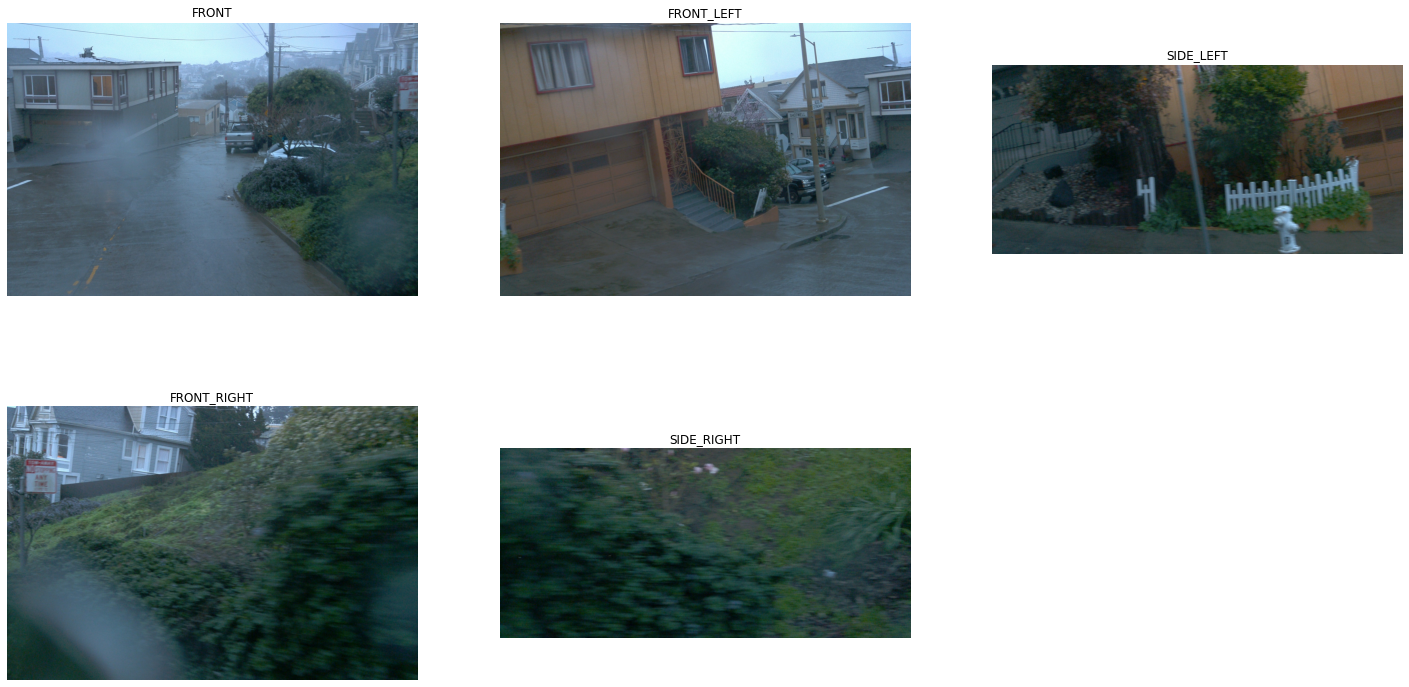

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 20))

def image_show(data, name, layout, cmap=None):
  """Show an image."""
  plt.subplot(*layout)
  plt.imshow(tf.image.decode_jpeg(data), cmap=cmap)
  plt.title(name)
  plt.grid(False)
  plt.axis('off')

for index, image in enumerate(frame.images):
  image_show(image.image, open_dataset.CameraName.Name.Name(image.name),
             [3, 3, index+1])

##Visualize Range Images

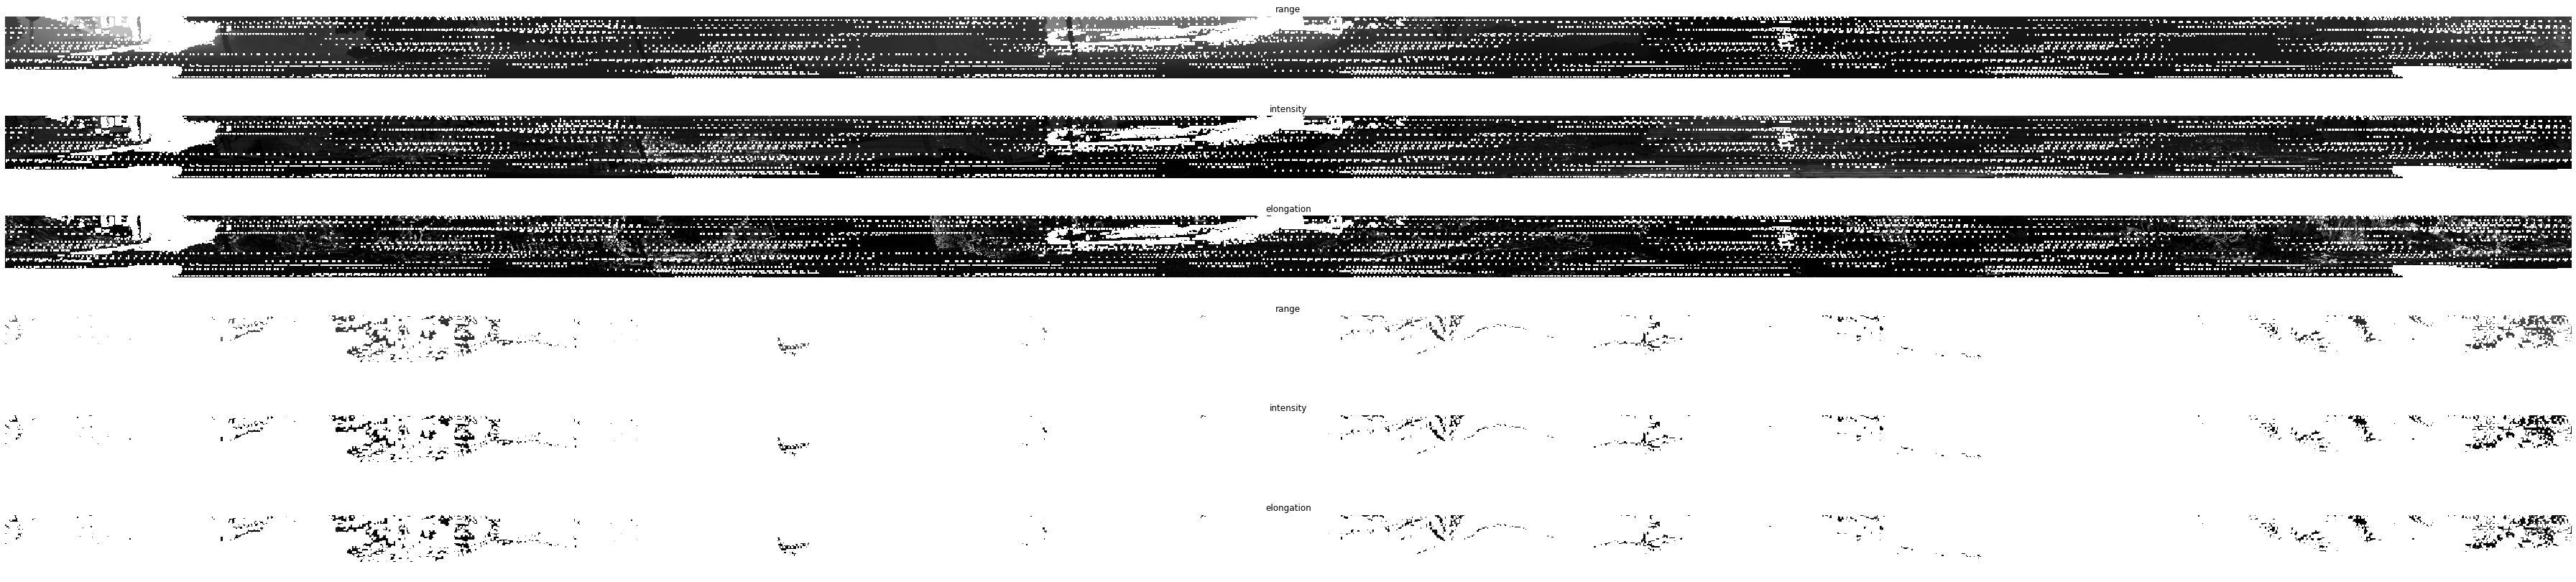

In [13]:
plt.figure(figsize=(64, 20))
def plot_range_image_helper(data, name, layout, vmin = 0, vmax=1, cmap='gray'):
  """Plots range image.

  Args:
    data: range image data
    name: the image title
    layout: plt layout
    vmin: minimum value of the passed data
    vmax: maximum value of the passed data
    cmap: color map
  """
  plt.subplot(*layout)
  plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title(name)
  plt.grid(False)
  plt.axis('off')

def get_range_image(laser_name, return_index):
  """Returns range image given a laser name and its return index."""
  return range_images[laser_name][return_index]

def show_range_image(range_image, layout_index_start = 1):
  """Shows range image.

  Args:
    range_image: the range image data from a given lidar of type MatrixFloat.
    layout_index_start: layout offset
  """
  range_image_tensor = tf.convert_to_tensor(range_image.data)
  range_image_tensor = tf.reshape(range_image_tensor, range_image.shape.dims)
  lidar_image_mask = tf.greater_equal(range_image_tensor, 0)
  range_image_tensor = tf.where(lidar_image_mask, range_image_tensor,
                                tf.ones_like(range_image_tensor) * 1e10)
  range_image_range = range_image_tensor[...,0] 
  range_image_intensity = range_image_tensor[...,1]
  range_image_elongation = range_image_tensor[...,2]
  plot_range_image_helper(range_image_range.numpy(), 'range',
                   [8, 1, layout_index_start], vmax=75, cmap='gray')
  plot_range_image_helper(range_image_intensity.numpy(), 'intensity',
                   [8, 1, layout_index_start + 1], vmax=1.5, cmap='gray')
  plot_range_image_helper(range_image_elongation.numpy(), 'elongation',
                   [8, 1, layout_index_start + 2], vmax=1.5, cmap='gray')
frame.lasers.sort(key=lambda laser: laser.name)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 0), 1)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 1), 4)

##Point Cloud Conversion and Visualization

In [14]:
points, cp_points = frame_utils.convert_range_image_to_point_cloud(frame,
                                                       range_images,
                                                       camera_projections,
                                                       range_image_top_pose)
points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose,
    ri_index=1)

# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

###Examine number of points in each lidar sensor.

First return.

In [15]:
print(points_all.shape)
print(cp_points_all.shape)
print(points_all[0:2])
for i in range(5):
  print(points[i].shape)
  print(cp_points[i].shape)

(171606, 3)
(171606, 6)
[[-1.91726074e+01 -6.54296875e-02  2.92002106e+00]
 [-1.72241211e+01 -1.46484375e-02  2.85127258e+00]]
(153830, 3)
(153830, 6)
(3844, 3)
(3844, 6)
(3894, 3)
(3894, 6)
(4794, 3)
(4794, 6)
(5244, 3)
(5244, 6)


Second return.

In [16]:
print(points_all_ri2.shape)
print(cp_points_all_ri2.shape)
print(points_all_ri2[0:2])
for i in range(5):
  print(points_ri2[i].shape)
  print(cp_points_ri2[i].shape)

(12074, 3)
(12074, 6)
[[-1.9289429e+01 -1.6601562e-02  2.9240036e+00]
 [-1.9253784e+01  3.7304688e-01  2.9274216e+00]]
(11340, 3)
(11340, 6)
(40, 3)
(40, 6)
(131, 3)
(131, 6)
(117, 3)
(117, 6)
(446, 3)
(446, 6)


###Show point cloud
3D point clouds are rendered using an internal tool, which is unfortunately not publicly available yet. Here is an example of what they look like.

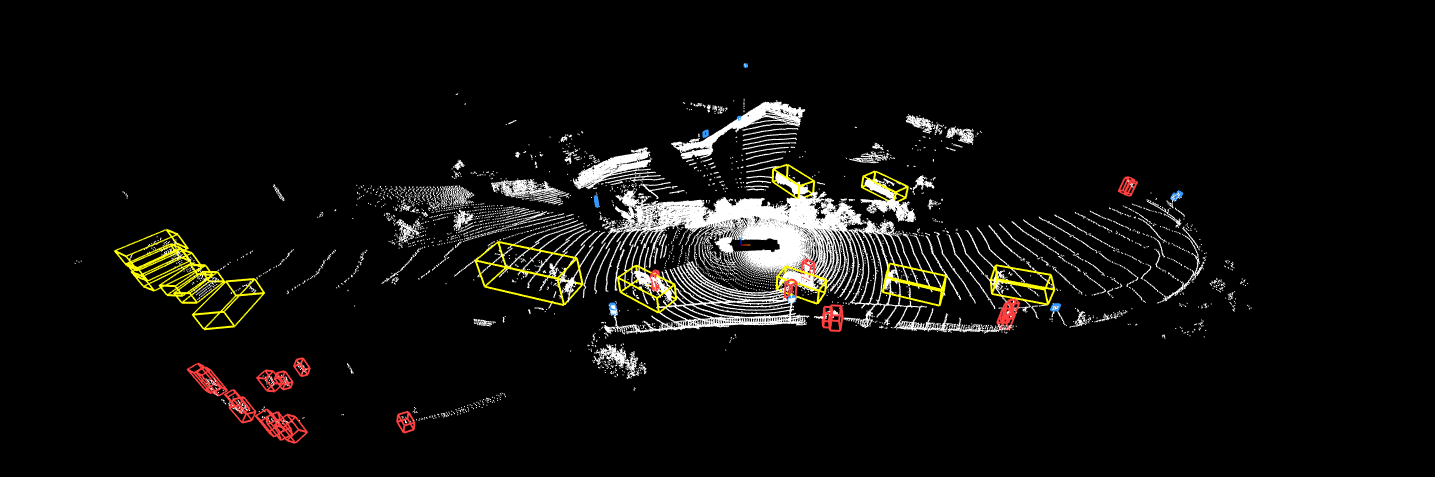

In [17]:
from IPython.display import Image, display
display(Image(point_cloud_path))

##Visualize Camera Projection

In [18]:
images = sorted(frame.images, key=lambda i:i.name)
cp_points_all_concat = np.concatenate([cp_points_all, points_all], axis=-1)
cp_points_all_concat_tensor = tf.constant(cp_points_all_concat)

# The distance between lidar points and vehicle frame origin.
points_all_tensor = tf.norm(points_all, axis=-1, keepdims=True)
cp_points_all_tensor = tf.constant(cp_points_all, dtype=tf.int32)

mask = tf.equal(cp_points_all_tensor[..., 0], images[0].name)

cp_points_all_tensor = tf.cast(tf.gather_nd(
    cp_points_all_tensor, tf.where(mask)), dtype=tf.float32)
points_all_tensor = tf.gather_nd(points_all_tensor, tf.where(mask))

projected_points_all_from_raw_data = tf.concat(
    [cp_points_all_tensor[..., 1:3], points_all_tensor], axis=-1).numpy()

In [19]:
def rgba(r):
  """Generates a color based on range.

  Args:
    r: the range value of a given point.
  Returns:
    The color for a given range
  """
  c = plt.get_cmap('jet')((r % 20.0) / 20.0)
  c = list(c)
  c[-1] = 0.5  # alpha
  return c

def plot_image(camera_image):
  """Plot a cmaera image."""
  plt.figure(figsize=(20, 12))
  plt.imshow(tf.image.decode_jpeg(camera_image.image))
  plt.grid("off")

def plot_points_on_image(projected_points, camera_image, rgba_func,
                         point_size=5.0):
  """Plots points on a camera image.

  Args:
    projected_points: [N, 3] numpy array. The inner dims are
      [camera_x, camera_y, range].
    camera_image: jpeg encoded camera image.
    rgba_func: a function that generates a color from a range value.
    point_size: the point size.

  """
  plot_image(camera_image)

  xs = []
  ys = []
  colors = []

  for point in projected_points:
    xs.append(point[0])  # width, col
    ys.append(point[1])  # height, row
    colors.append(rgba_func(point[2]))

  plt.scatter(xs, ys, c=colors, s=point_size, edgecolors="none")

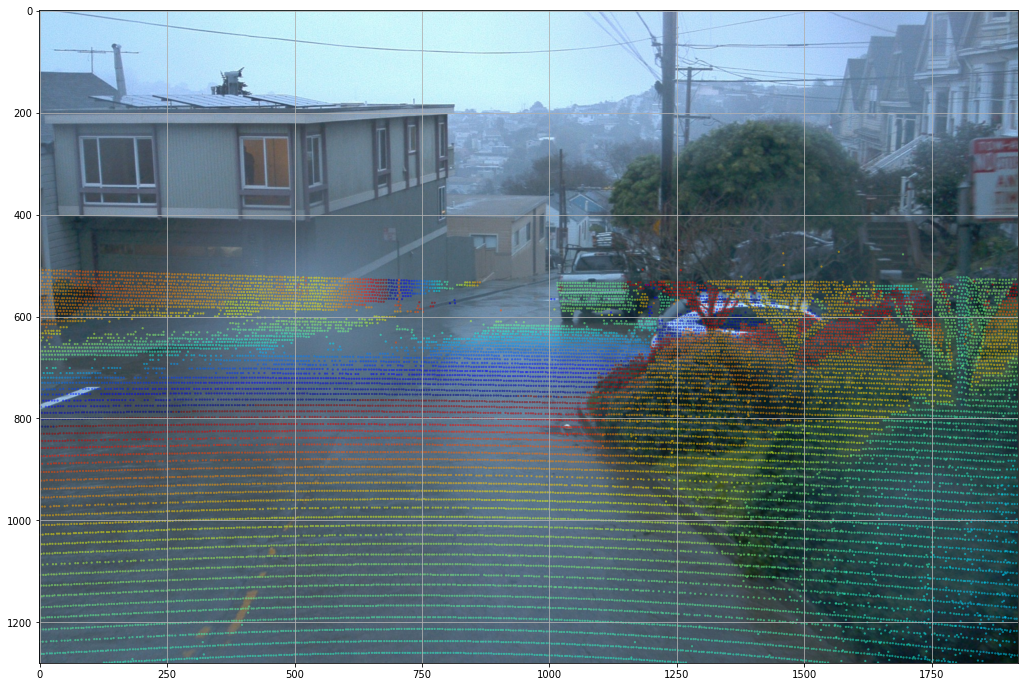

In [20]:
plot_points_on_image(projected_points_all_from_raw_data,
                     images[0], rgba, point_size=5.0)